### About:
The goal of this notebook is to perform a very simple sampling task using tensorflow probability.
Much of this is adapted from https://github.com/ksachdeva/rethinking-tensorflow-probability.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys

sys.path.append("../src")

In [ ]:
import collections
import numpy as np
import arviz as az
import pandas as pd

import scipy.stats as stats
from matplotlib import pyplot as plt

In [ ]:
from sampling import sample_posterior

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [ ]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
CHERRY_BLOSSOMS_DATASET_PATH = f"{_BASE_URL}/cherry_blossoms.csv"

In [7]:
howel_data = pd.read_csv(HOWELL_DATASET_PATH, sep=";", header=0)
howel_data_adult = howel_data.query("age > 18")

In [8]:
howel_data_adult.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [9]:
def model():
    """
    Tensorflow Baysian inference model. From section 4.1 in 
    statistical rethinking. 
    Code adapted from  
    """

    def _generator():
        mu = yield Root(tfd.Normal(loc=0.0, scale=200.0))
        sigma = yield Root(tfd.Exponential(rate=0.1))
        height = yield tfd.Independent(
            tfd.Normal(loc=mu[..., None], scale=sigma[..., None]),
            reinterpreted_batch_ndims=1,
        )

    return tfd.JointDistributionCoroutine(_generator, validate_args=True)


model_instance = model()

In [10]:
prior_predictive_distribution = model_instance.sample(5000)[-1]

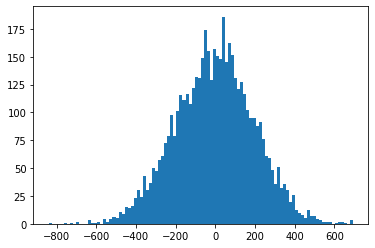

In [11]:
plt.hist(np.squeeze(prior_predictive_distribution.numpy()), bins=100);

In [12]:
raw_trace, az_inference_object = sample_posterior(
    model_instance,
    observed_data=(howel_data_adult.weight.values,),
    params=["mu", "sigma"],
    method="nuts",
    num_samples=1000,
)

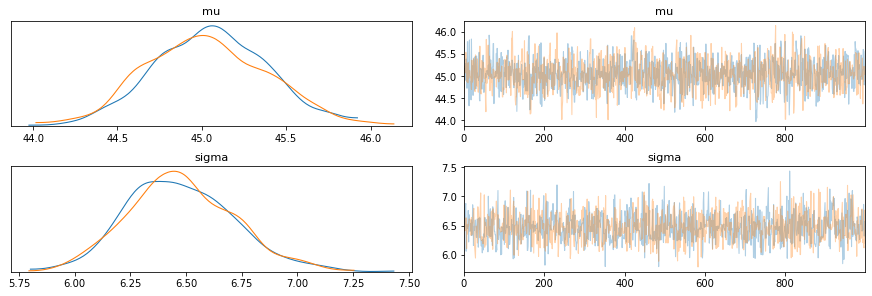

In [13]:
# the parameter chains are reasonable.
az.plot_trace(raw_trace);

45.04554285549133 6.455219659733352


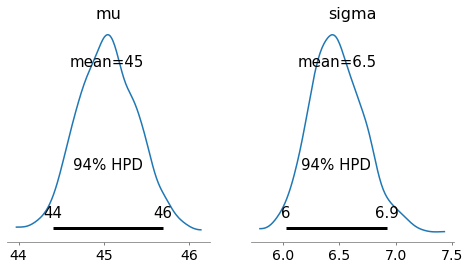

In [15]:
# inference looks accurate.
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_posterior(az_inference_object, ax=ax, var_names=["mu", "sigma"])
print(howel_data_adult["weight"].mean(), howel_data_adult["weight"].std())

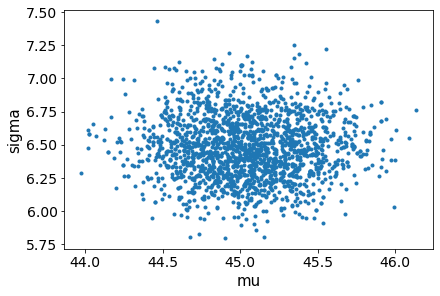

In [16]:
az.plot_pair(az_inference_object)

/home/worker/.local/share/virtualenvs/worker-Q7nhheP5/lib/python3.7/site-packages/arviz/plots/plot_utils.py:793: UserWarning: kde plot failed, you may want to check your data
  warnings.warn("kde plot failed, you may want to check your data")


IndexError: index 1 is out of bounds for axis 0 with size 1

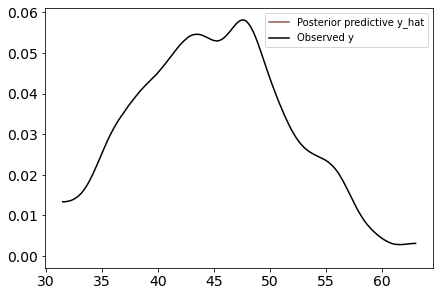

In [17]:
# There seems to be a problem with the posterior predictive data
az.plot_ppc(az_inference_object, data_pairs={"y": "y_hat"}, kind="kde");

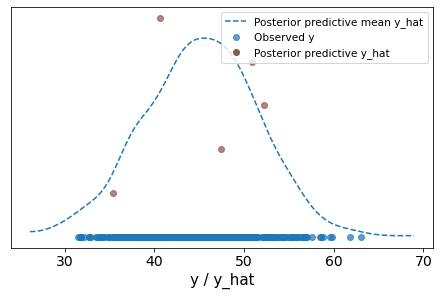

In [18]:
# Oddly the kde and scatter data are somewhat at odds with one another.
az.plot_ppc(az_inference_object, data_pairs={"y": "y_hat"}, kind="scatter");

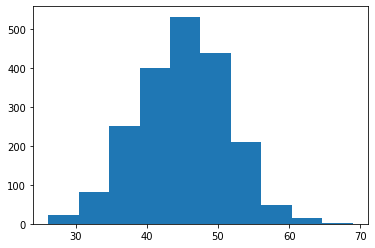

In [19]:
# the raw data seems ok.
plt.hist(np.ravel(az_inference_object.posterior_predictive.to_array()));

In [20]:
# I don't see any missing data
print(np.isnan(np.ravel(az_inference_object.posterior_predictive.to_array())).sum())
print((~np.isnan(np.ravel(az_inference_object.posterior_predictive.to_array()))).sum())

0
2000


In [21]:
az.summary(raw_trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu,45.040,0.348,44.407,45.696,0.009,0.006,1570.0,1569.0,1561.0,1193.0,1.0
sigma,6.477,0.237,6.025,6.921,0.006,0.004,1613.0,1613.0,1599.0,1490.0,1.0
